In [1]:
import warnings

import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

from matplotlib.lines import Line2D

warnings.simplefilter(action='ignore', category=FutureWarning)

# Zero inflated models

In this notebook, we will describe zero inflated outcomes and why the data generating process behind these outcomes requires a special class of generalized linear models: zero-inflated Poisson (ZIP) and hurdle Poisson. Subsequently, we will describe and implement each model using a set of zero-inflated data from ecology. Along the way, we will also use the `interpret` sub-package to interpret the predictions and parameters of the models.

## Zero inflated outcomes

Sometimes, an observation is not generated from a single process, but from a _mixture_ of processes. Whenever there is a mixture of processes generating an observation, a mixture model may be more appropriate. A mixture model uses more than one probability distribution to model the data. Count data are more susceptible to needing a mixture model as it is common to have a large number of zeros **and** values greater than zero.  A zero means "nothing happened", and this can be either because the rate of events is low, or because the process that generates the events was never "triggered". For example, in health service utilization data (the number of times a patient used a service during a given time period), a large number of zeros represents patients with no utilization during the time period. However, some patients do use a service which is a result of some "triggered process". 

There are two popular classes of models for modeling zero-inflated data: (1) ZIP, and (2) hurdle Poisson. First, the ZIP model is described and how to implement it in Bambi is outlined. Subsequently, the hurdle Poisson model and how to implement it is outlined thereafter.

## Zero inflated Poisson

To model zero-inflated outcomes, the ZIP model uses a distribution that mixes two data generating processes. The first process generates zeros, and the second process uses a Poisson distribution to generate counts (of which some may be zero). The result of this mixture is a distribution that can be described as

$$P(Y=0) = (1 - \psi) + \psi e^{-\mu}$$

$$P(Y=y_i) = \psi \frac{e^{-\mu} \mu_{i}^y}{y_{i}!} \ \text{for} \ y_i = 1, 2, 3,...,n$$

where $y_i$ is the outcome, $\mu$ is the mean of the Poisson process where $\mu \ge 0$, and $\psi$ is the probability of the Poisson process where $0 \lt \psi \lt 1$. To understand how these two processes are "mixed", let's simulate some data using the two process equations above (taken from the PyMC [docs](https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.ZeroInflatedPoisson.html)).

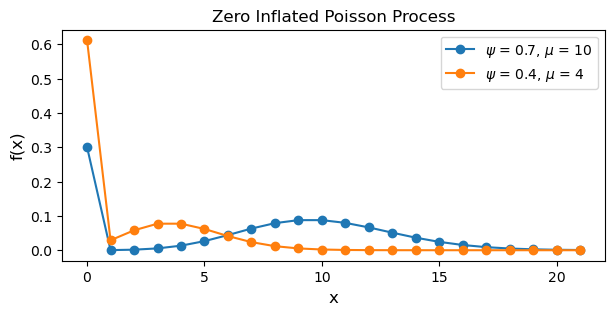

In [2]:
x = np.arange(0, 22)
psis = [0.7, 0.4]
mus = [10, 4]
plt.figure(figsize=(7, 3))
for psi, mu in zip(psis, mus):
    pmf = stats.poisson.pmf(x, mu)
    pmf[0] = (1 - psi) + pmf[0] # 1.) generate zeros
    pmf[1:] =  psi * pmf[1:] # 2.) generate counts
    pmf /= pmf.sum() # normalize to get probabilities
    plt.plot(x, pmf, '-o', label='$\\psi$ = {}, $\\mu$ = {}'.format(psi, mu))

plt.title("Zero Inflated Poisson Process")
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

Notice how the blue line, corresponding to a higher $\psi$ and $\mu$, has a higher rate of counts and less zeros. Additionally, the inline comments above describe the first and second process generating the data.

### ZIP regression model

The equations above only describe the ZIP distribution. However, predictors can be added to make this a regression model. Suppose we have a response variable $Y$, which represents the number of events that occur during a time period, and $p$ predictors $X_1, X_2, ..., X_p$. We can model the parameters of the ZIP distribution as a linear combination of the predictors.

$$Y_i \sim \text{ZIPoisson}(\mu_i, \psi_i)$$

$$g(\mu_i) = \beta_0 + \beta_1 X_{1i} + ... + \beta_p X_{pi}$$

$$h(\psi_i) = \alpha_0 + \alpha_1 X_{1i} + ... + \alpha_p X_{pi}$$

where $g$ and $h$ are the link functions for each parameter. Bambi, by default, uses the log link for $g$ and the logit link for $h$. Notice how there are two linear models and two link functions: one for each parameter in the $\text{ZIPoisson}$. The parameters of the linear model differ, because any predictor such as $X$ may be associated differently with each part of the mixture. Actually, you don't even need to use the same predictors in both linear models—but this beyond the scope of this notebook.

#### The fish dataset

To demonstrate the ZIP regression model, we model and predict how many fish are caught by visitors at a state park using survey [data](https://stats.idre.ucla.edu/stat/data/fish.csv). Many visitors catch zero fish, either because they did not fish at all, or because they were unlucky. The dataset contains data on 250 groups that went to a state park to fish. Each group was questioned about how many fish they caught (`count`), how many children were in the group (`child`), how many people were in the group (`persons`), if they used a live bait (`livebait`) and whether or not they brought a camper to the park (`camper`).

In [3]:
fish_data = pd.read_csv("https://stats.idre.ucla.edu/stat/data/fish.csv")
cols = ["count", "livebait", "camper", "persons", "child"]
fish_data = fish_data[cols]
fish_data["livebait"] = pd.Categorical(fish_data["livebait"])
fish_data["camper"] = pd.Categorical(fish_data["camper"])
fish_data = fish_data[fish_data["count"] < 60] # remove outliers

In [4]:
fish_data.head()

,count,livebait,camper,persons,child
0,0,0,0,1,0
1,0,1,1,1,0
2,0,1,0,1,0
3,0,1,1,2,1
4,1,1,0,1,0


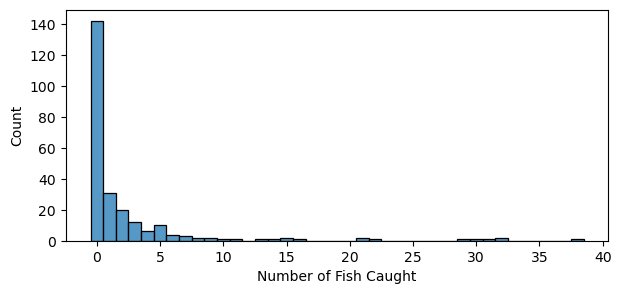

In [5]:
# Excess zeros, and skewed count
plt.figure(figsize=(7, 3))
sns.histplot(fish_data["count"], discrete=True)
plt.xlabel("Number of Fish Caught");

To fit a ZIP regression model, we pass `family=zero_inflated_poisson` to the `bmb.Model` constructor.

In [6]:
zip_model = bmb.Model(
    "count ~ livebait + camper + persons + child", 
    fish_data, 
    family='zero_inflated_poisson'
)

zip_idata = zip_model.fit(
    draws=1000, 
    target_accept=0.95, 
    random_seed=1234, 
    chains=4
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [psi, Intercept, livebait, camper, persons, child]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Let's take a look at the model components. Why is there only one linear model and link function defined for $\mu$. Where is the linear model and link function for $\psi$? By default, the "main" (or first) formula is defined for the parent parameter; in this case $\mu$. Since we didn't pass an additional formula for the non-parent parameter $\psi$, $\psi$ was never modeled as a function of the predictors as explained above. If we want to model both $\mu$ and $\psi$ as a function of the predictor, we need to expicitly pass two formulas. 

In [7]:
zip_model

       Formula: count ~ livebait + camper + persons + child
        Family: zero_inflated_poisson
          Link: mu = log
  Observations: 248
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 9.5283)
            livebait ~ Normal(mu: 0.0, sigma: 7.2685)
            camper ~ Normal(mu: 0.0, sigma: 5.0733)
            persons ~ Normal(mu: 0.0, sigma: 2.2583)
            child ~ Normal(mu: 0.0, sigma: 2.9419)
        
        Auxiliary parameters
            psi ~ Beta(alpha: 2.0, beta: 2.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [8]:
formula = bmb.Formula(
    "count ~ livebait + camper + persons + child", # parent parameter mu
    "psi ~ livebait + camper + persons + child"    # non-parent parameter psi
)

zip_model = bmb.Model(
    formula, 
    fish_data, 
    family='zero_inflated_poisson'
)

zip_idata = zip_model.fit(
    draws=1000, 
    target_accept=0.95, 
    random_seed=1234, 
    chains=4
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, livebait, camper, persons, child, psi_Intercept, psi_livebait, psi_camper, psi_persons, psi_child]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [9]:
zip_model

       Formula: count ~ livebait + camper + persons + child
                psi ~ livebait + camper + persons + child
        Family: zero_inflated_poisson
          Link: mu = log
                psi = logit
  Observations: 248
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 9.5283)
            livebait ~ Normal(mu: 0.0, sigma: 7.2685)
            camper ~ Normal(mu: 0.0, sigma: 5.0733)
            persons ~ Normal(mu: 0.0, sigma: 2.2583)
            child ~ Normal(mu: 0.0, sigma: 2.9419)
    target = psi
        Common-level effects
            psi_Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            psi_livebait ~ Normal(mu: 0.0, sigma: 1.0)
            psi_camper ~ Normal(mu: 0.0, sigma: 1.0)
            psi_persons ~ Normal(mu: 0.0, sigma: 1.0)
            psi_child ~ Normal(mu: 0.0, sigma: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object

Now, both $\mu$ and $\psi$ are defined as a function of a linear combination of the predictors. Additionally, we can see that the log and logit link functions are defined for $\mu$ and $\psi$, respectively.

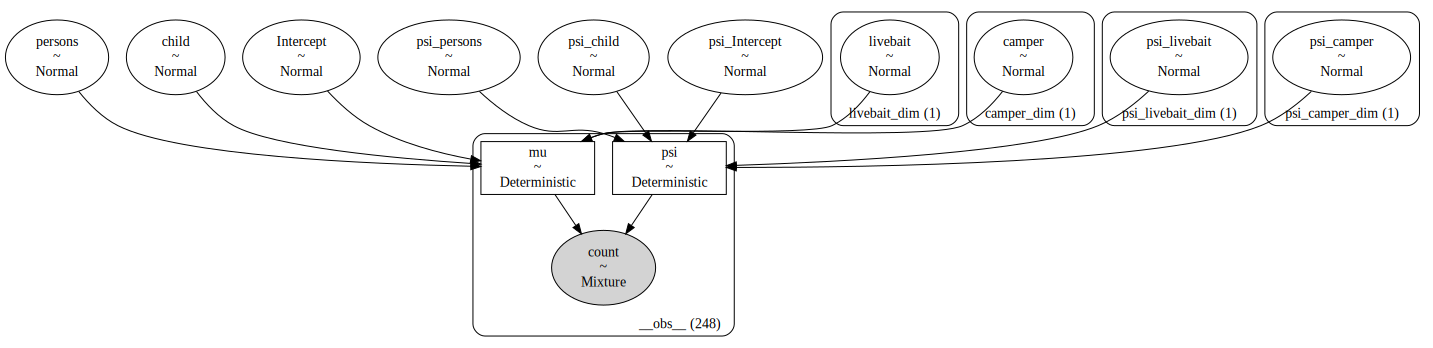

In [10]:
zip_model.graph()

Since each parameter has a different link function, and each parameter has a different meaning, we must be careful on how the coefficients are interpreted. Coefficients without the substring "psi" correspond to the $\mu$ parameter (the mean of the Poisson process) and are on the log scale. Coefficients with the substring "psi" correspond to the $\psi$ parameter (this can be thought of as the log-odds of non-zero data) and are on the logit scale. Interpreting these coefficients can be easier with the `interpret` sub-package. Below, we will show how to use this sub-package to interpret the coefficients conditional on a set of the predictors.

In [11]:
az.summary(
    zip_idata, 
    var_names=["Intercept", "livebait", "camper", "persons", "child"], 
    filter_vars="like"
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.585,0.306,-2.148,-0.990,0.005,0.005,3836.0,3067.0,1.0
livebait[1],1.618,0.271,1.128,2.130,0.004,0.004,4427.0,3020.0,1.0
camper[1],0.265,0.099,0.079,0.448,0.001,0.002,5863.0,2983.0,1.0
persons,0.616,0.047,0.531,0.704,0.001,0.001,4157.0,2759.0,1.0
child,-0.801,0.097,-0.982,-0.621,0.002,0.001,3854.0,3250.0,1.0
psi_Intercept,-1.437,0.794,-2.857,0.083,0.013,0.011,3822.0,3183.0,1.0
psi_livebait[1],-0.195,0.667,-1.409,1.084,0.010,0.011,4384.0,3141.0,1.0
psi_camper[1],0.842,0.328,0.179,1.408,0.005,0.006,4972.0,2830.0,1.0
psi_persons,0.915,0.194,0.553,1.273,0.003,0.003,4209.0,2872.0,1.0
psi_child,-1.893,0.303,-2.460,-1.323,0.005,0.004,4060.0,3533.0,1.0


#### Interpret model parameters

Since we have fit a distributional model, we can leverage the `plot_predictions()` function in the `interpret` sub-package to visualize how the $\text{ZIPoisson}$ parameters $\mu$ and $\psi$ vary as a covariate changes. 

Default computed for conditional variable: persons
Default computed for unspecified variable: camper, child, livebait
Default computed for conditional variable: persons
Default computed for unspecified variable: camper, child, livebait


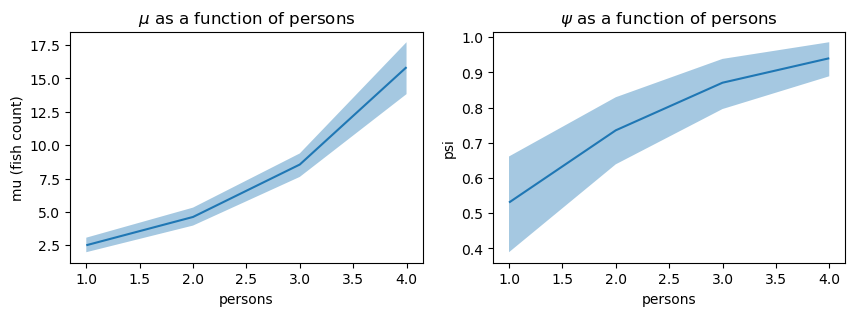

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

bmb.interpret.plot_predictions(
    zip_model,
    zip_idata,
    conditional="persons",
    ax=ax[0]
)
ax[0].set_ylabel("mu (fish count)")
ax[0].set_title("$\\mu$ as a function of persons")

bmb.interpret.plot_predictions(
    zip_model,
    zip_idata,
    conditional="persons",
    target="psi",
    ax=ax[1]
)
ax[1].set_title("$\\psi$ as a function of persons");

Interpreting the left plot (the $\mu$ parameter) as the number of people in a group fishing increases, so does the number of fish caught. The right plot (the $\psi$ parameter) shows that as the number of people in a group fishing increases, the probability of the Poisson process increases. One interpretation of this is that as the number of people in a group increases, the probability of catching no fish decreases.

#### Posterior predictive distribution

Lastly, let's plot the posterior predictive distribution against the observed data to see how well the model fits the data. To plot the samples, a utility function is defined below to assist in the plotting of discrete values.

In [13]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], c[1] * amount, c[2])

def plot_ppc_discrete(idata, bins, ax):
    
    def add_discrete_bands(x, lower, upper, ax, **kwargs):
        for i, (l, u) in enumerate(zip(lower, upper)):
            s = slice(i, i + 2)
            ax.fill_between(x[s], [l, l], [u, u], **kwargs)

    var_name = list(idata.observed_data.data_vars)[0]
    y_obs = idata.observed_data[var_name].to_numpy()
    
    counts_list = []
    for draw_values in az.extract(idata, "posterior_predictive")[var_name].to_numpy().T:
        counts, _ = np.histogram(draw_values, bins=bins)
        counts_list.append(counts)
    counts_arr = np.stack(counts_list)

    qts_90 = np.quantile(counts_arr, (0.05, 0.95), axis=0)
    qts_70 = np.quantile(counts_arr, (0.15, 0.85), axis=0)
    qts_50 = np.quantile(counts_arr, (0.25, 0.75), axis=0)
    qts_30 = np.quantile(counts_arr, (0.35, 0.65), axis=0)
    median = np.quantile(counts_arr, 0.5, axis=0)

    colors = [adjust_lightness("C0", x) for x in [1.8, 1.6, 1.4, 1.2, 0.9]]

    add_discrete_bands(bins, qts_90[0], qts_90[1], ax=ax, color=colors[0])
    add_discrete_bands(bins, qts_70[0], qts_70[1], ax=ax, color=colors[1])
    add_discrete_bands(bins, qts_50[0], qts_50[1], ax=ax, color=colors[2])
    add_discrete_bands(bins, qts_30[0], qts_30[1], ax=ax, color=colors[3])

    
    ax.step(bins[:-1], median, color=colors[4], lw=2, where="post")
    ax.hist(y_obs, bins=bins, histtype="step", lw=2, color="black", align="mid")
    handles = [
        Line2D([], [], label="Observed data", color="black", lw=2),
        Line2D([], [], label="Posterior predictive median", color=colors[4], lw=2)
    ]
    ax.legend(handles=handles)
    return ax

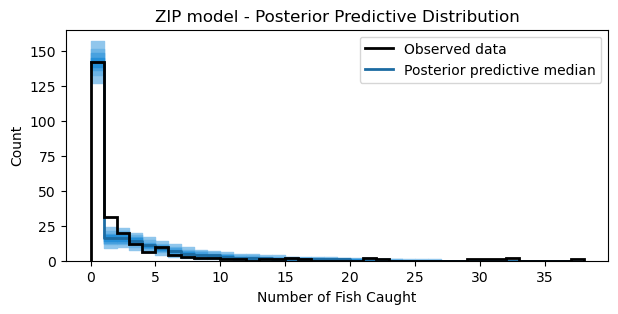

In [14]:
zip_pps = zip_model.predict(idata=zip_idata, kind="response", inplace=False)

bins = np.arange(39)
fig, ax = plt.subplots(figsize=(7, 3))
ax = plot_ppc_discrete(zip_pps, bins, ax)
ax.set_xlabel("Number of Fish Caught")
ax.set_ylabel("Count")
ax.set_title("ZIP model - Posterior Predictive Distribution");

The model captures the number of zeros accurately. However, the model seems to slightly underestimate the counts 1 and 2. Nonetheless, the plot shows that the model captures the overall distribution of counts reasonably well.

## Hurdle Poisson

Both ZIP and hurdle models both use two processes to generate data. The two models differ in their conceptualization of how the zeros are generated. In $\text{ZIPoisson}$, the zeroes can come from any of the processes, while in the hurdle Poisson they come only from one of the processes. Thus, a hurdle model assumes zero and positive values are generated from two independent processes. In the hurdle model, there are two components: (1) a "structural" process such as a binary model for modeling whether the response variable is zero or not, and (2) a process using a truncated model such as a truncated Poisson for modeling the counts. The result of these two components is a distribution that can be described as

$$P(Y=0) = 1 - \psi$$

$$P(Y=y_i) = \psi \frac{e^{-\mu_i}\mu_{i}^{y_i} / y_i!}{1 - e^{-\mu_i}} \ \text{for} \ y_i = 1, 2, 3,...,n$$

where $y_i$ is the outcome, $\mu$ is the mean of the Poisson process where $\mu \ge 0$, and $\psi$ is the probability of the Poisson process where $0 \lt \psi \lt 1$. The numerator of the second equation is the Poisson probability mass function, and the denominator is one minus the Poisson cumulative distribution function. This is a lot to digest. Again, let's simulate some data to understand how data is generated from this process.

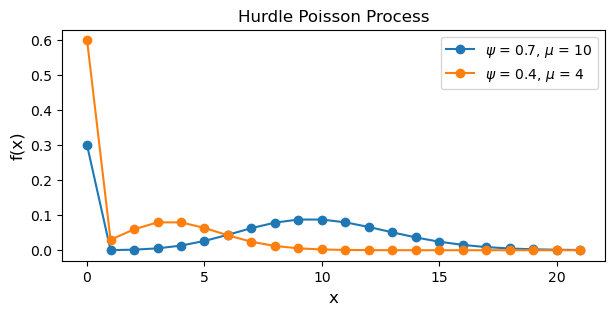

In [15]:
x = np.arange(0, 22)
psis = [0.7, 0.4]
mus = [10, 4]

plt.figure(figsize=(7, 3))
for psi, mu in zip(psis, mus):
    pmf = stats.poisson.pmf(x, mu) # pmf evaluated at x given mu
    cdf = stats.poisson.cdf(0, mu) # cdf evaluated at 0 given mu
    pmf[0] = 1 - psi # 1.) generate zeros
    pmf[1:] =  (psi * pmf[1:]) / (1 - cdf) # 2.) generate counts
    pmf /= pmf.sum() # normalize to get probabilities
    plt.plot(x, pmf, '-o', label='$\\psi$ = {}, $\\mu$ = {}'.format(psi, mu))

plt.title("Hurdle Poisson Process")
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

The differences between the ZIP and hurdle models are subtle. Notice how in the code for the hurdle Poisson process, the zero counts are generate by `(1 - psi)` versus `(1 - psi) + pmf[0]` for the ZIP process. Additionally, the positive observations are generated by the process `(psi * pmf[1:]) / (1 - cdf)` where the numerator is a vector of probabilities for positive counts scaled by $\psi$ and the denominator uses the Poisson cumulative distribution function to evaluate the probability a count is greater than 0.

### Hurdle regression model

To add predictors in the hurdle model, we follow the same specification as in the _ZIP regression model_ section since both models have the same structure. The only difference is that the hurdle model uses a truncated Poisson distribution instead of a ZIP distribution. Right away, we will model both the parent and non-parent parameter as a function of the predictors.

In [16]:
hurdle_formula = bmb.Formula(
    "count ~ livebait + camper + persons + child", # parent parameter mu
    "psi ~ livebait + camper + persons + child"    # non-parent parameter psi
)

hurdle_model = bmb.Model(
    hurdle_formula, 
    fish_data, 
    family='hurdle_poisson'
)

hurdle_idata = hurdle_model.fit(
    draws=1000, 
    target_accept=0.95, 
    random_seed=1234, 
    chains=4
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, livebait, camper, persons, child, psi_Intercept, psi_livebait, psi_camper, psi_persons, psi_child]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [17]:
hurdle_model

       Formula: count ~ livebait + camper + persons + child
                psi ~ livebait + camper + persons + child
        Family: hurdle_poisson
          Link: mu = log
                psi = logit
  Observations: 248
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 9.5283)
            livebait ~ Normal(mu: 0.0, sigma: 7.2685)
            camper ~ Normal(mu: 0.0, sigma: 5.0733)
            persons ~ Normal(mu: 0.0, sigma: 2.2583)
            child ~ Normal(mu: 0.0, sigma: 2.9419)
    target = psi
        Common-level effects
            psi_Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            psi_livebait ~ Normal(mu: 0.0, sigma: 1.0)
            psi_camper ~ Normal(mu: 0.0, sigma: 1.0)
            psi_persons ~ Normal(mu: 0.0, sigma: 1.0)
            psi_child ~ Normal(mu: 0.0, sigma: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object return

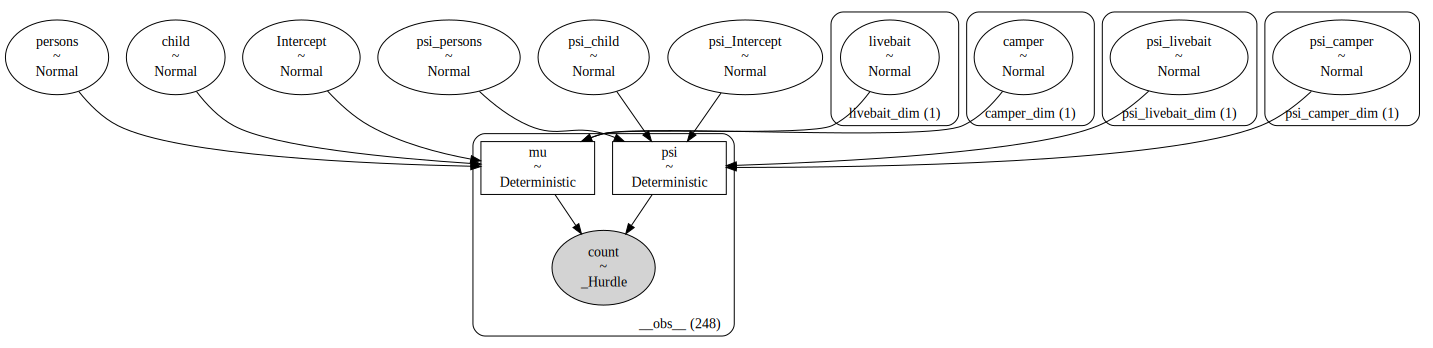

In [18]:
hurdle_model.graph()

As the same link functions are used for ZIP and Hurdle model, the coefficients can be interpreted in a similar manner.

In [19]:
az.summary(
    hurdle_idata,
    var_names=["Intercept", "livebait", "camper", "persons", "child"], 
    filter_vars="like"
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.614,0.361,-2.300,-0.943,0.006,0.006,3901.0,2829.0,1.0
livebait[1],1.657,0.332,1.067,2.304,0.005,0.006,4551.0,2620.0,1.0
camper[1],0.270,0.099,0.076,0.449,0.001,0.002,5652.0,2655.0,1.0
persons,0.612,0.045,0.527,0.695,0.001,0.001,4422.0,2556.0,1.0
child,-0.791,0.098,-0.977,-0.609,0.001,0.001,4396.0,3053.0,1.0
psi_Intercept,-2.793,0.586,-3.940,-1.739,0.008,0.008,5258.0,3247.0,1.0
psi_livebait[1],0.779,0.439,0.010,1.646,0.005,0.008,6921.0,2841.0,1.0
psi_camper[1],0.850,0.303,0.255,1.383,0.004,0.005,5325.0,3033.0,1.0
psi_persons,1.042,0.178,0.711,1.376,0.003,0.003,3965.0,2976.0,1.0
psi_child,-2.009,0.279,-2.517,-1.456,0.004,0.005,4025.0,3216.0,1.0


#### Posterior predictive samples

As with the ZIP model above, we plot the posterior predictive distribution against the observed data to see how well the model fits the data.

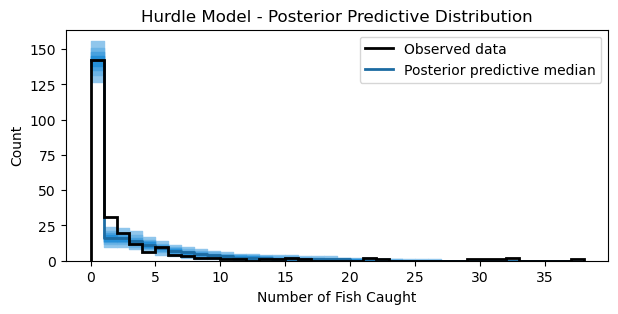

In [20]:
hurdle_pps = hurdle_model.predict(idata=hurdle_idata, kind="response", inplace=False)

bins = np.arange(39)
fig, ax = plt.subplots(figsize=(7, 3))
ax = plot_ppc_discrete(hurdle_pps, bins, ax)
ax.set_xlabel("Number of Fish Caught")
ax.set_ylabel("Count")
ax.set_title("Hurdle Model - Posterior Predictive Distribution");

The plot looks similar to the ZIP model above. Nonetheless, the plot shows that the model captures the overall distribution of counts reasonably well.

## Summary

In this notebook, two classes of models (ZIP and hurdle Poisson) for modeling zero-inflated data were presented and implemented in Bambi. The difference of the data generating process between the two models differ in how zeros are generated. The ZIP model uses a distribution that mixes two data generating processes. The first process generates zeros, and the second process uses a Poisson distribution to generate counts (of which some may be zero). The hurdle Poisson also uses two data generating processes, but doesn't "mix" them. A process is used for generating zeros such as a binary model for modeling whether the response variable is zero or not, and a second process for modeling the counts. These two proceses are independent of each other.

The dataset used to demonstrate the two models had a large number of zeros. These zeros appeared because the group doesn't fish, or because they fished, but caught zero fish. Because zeros could be generated due to two different reasons, the ZIP model, which allows zeros to be generated from a mixture of processes, seems to be more appropriate for this datset.

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Sep 28 2025

Python implementation: CPython
Python version       : 3.13.7
IPython version      : 9.4.0

bambi     : 0.14.1.dev58+gb25742785.d20250928
arviz     : 0.22.0
matplotlib: 3.10.6
pandas    : 2.3.2
scipy     : 1.16.2
seaborn   : 0.13.2
numpy     : 2.3.3

Watermark: 2.5.0

